<a href="https://colab.research.google.com/github/adam-matic/tracing_images/blob/master/LebedevV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and function definitions

In [0]:
from numpy import *
from matplotlib.pyplot import *
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.fftpack as fp
from numba import jit, njit
import pandas as pd
import scipy.stats as stats

class empty:
  pass

@njit
def generate_lebedev_trajectory(t, q_t, x0 = 0, y0 = 0, dx0 = 2, dy0 = -1, ddx0 = -1, ddy0 = 0, dt = 0.001):  
  N = len(t)
  x = zeros(N); dx = zeros(N); ddx = zeros(N)
  y = zeros(N); dy = zeros(N); ddy = zeros(N)
  x[0] = x0;   dx[0] = dx0;   ddx[0] = ddx0
  y[0] = y0;   dy[0] = dy0;   ddy[0] = ddy0
  for i in range(1, N):
    ddx[i] = ddx[i-1] - dt * dx[i-1] * q_t[i-1]
    dx[i] = dx[i-1] + dt * ddx[i]
    x[i] = x[i-1] + dt * dx[i]
    ddy[i] = ddy[i-1] - dt * dy[i-1] * q_t[i-1]
    dy[i] = dy[i-1] + dt * ddy[i]
    y[i] = y[i-1] + dt * dy[i]    
  return x, y, dx, dy, ddx, ddy

@jit
def get_pure_trajectory(x0=0, y0=0, eps=1.2, v=2, th0=1, N=2, scale=220, beta=2.0 / 3.0, k=2, dtheta = 0.001, dt = 0.001):
  theta = arange(th0, math.pi*N + th0, dtheta)
  thsub = theta - th0
  xs = x0 + cumsum(scale * dtheta * cos(theta) * exp(eps * sin(v * thsub)))
  ys = y0 + cumsum(scale * dtheta * sin(theta) * exp(eps * sin(v * thsub)))
  R_exp_beta = exp(beta * eps * sin(v * thsub))
  t_theta = cumsum(dtheta * R_exp_beta / k)
  new_time = arange(0, t_theta[-1], dt)
  xspl = interpolate.UnivariateSpline(t_theta, xs, k=3, s=0)
  yspl = interpolate.UnivariateSpline(t_theta, ys, k=3, s=0)
  xo = xspl(new_time)
  yo = yspl(new_time)
  return xo, yo, new_time

def butter_filter(x, y, cutoff, samples_per_s=200, filter_order = 2):
  B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
  xs = signal.filtfilt(B, A, x)
  ys = signal.filtfilt(B, A, y)
  return xs, ys

def analyze(xs, ys, ts, dt=0.001):
  d = empty()
  xspl = interpolate.UnivariateSpline(ts, xs, k=3, s=0)
  yspl = interpolate.UnivariateSpline(ts, ys, k=3, s=0)
  d.t = arange(ts[0], ts[-1], dt)
  d.x = xspl(d.t)
  d.y = yspl(d.t)
  d.xvel = xspl.derivative(1)(d.t)
  d.yvel = yspl.derivative(1)(d.t)
  d.xacc = xspl.derivative(2)(d.t)
  d.yacc = yspl.derivative(2)(d.t)
  d.xjerk = xspl.derivative(3)(d.t)
  d.yjerk = yspl.derivative(3)(d.t)
  d.J = sum(sqrt(d.xjerk**2 + d.yjerk**2)) * dt
  d.V = sqrt(d.xvel**2.0 + d.yvel**2.0)
  D0 = abs(d.yacc * d.xvel - d.xacc * d.yvel)
  d.D = asarray([NaN if dd == 0.0 else dd for dd in D0])
  d.R = (d.V**3.0) / d.D
  d.C = 1.0 / d.R
  d.A = d.V / d.R
  d.ds = d.V / dt
  C_clean = d.C[isfinite(d.C)]
  A_clean = d.A[isfinite(d.A)]
  d.logC = log10(C_clean)
  d.logA = log10(A_clean)
  d.V_mean = mean(d.V)
  d.A_mean = mean(A_clean)
  d.beta, d.offset, r, p_v, std_err = stats.linregress(d.logC, d.logA)
  d.r2 = r * r
  return d

@njit
def distance(x1, y1, x2, y2):
  return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

@njit
def triangle_area(a, b, c):
  s = (a + b + c) / 2
  area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
  return area

@njit
def get_times(ds, C, target_time, target_beta):
  dt = ds / (C ** (target_beta - 1))
  t0 = cumsum(dt)
  t = t0 * (target_time/ t0[-1]) 
  return t

@njit
def retrack(x, y, t, target_beta, target_time=None):
  if (not target_time):
    target_time = t[-1]
  ts = zeros(len(t))  
  for i in range(1, len(x) - 1):
    a = distance(x[i-1], y[i-1], x[i], y[i])
    b = distance(x[i+1], y[i+1], x[i], y[i])
    c = distance(x[i+1], y[i+1], x[i-1], y[i-1])
    C = (4 * triangle_area(a, b, c)) / (a * b * c)
    dt = a / ( C**(target_beta - 1))
    ts[i] = ts[i-1] + dt  
  t0 = ts * (target_time/ ts[-2]) 
  #print((target_time/ ts[-2]) )
  d = analyze(x[:-1], y[:-1], t0[:-1], dt=0.001)
  return d

@jit
def get_fft(w, sample_rate):
  n = len(w)
  k = arange(n)
  T = n / sample_rate
  frq = (k / T)[range(n // 2)]
  Y = abs(fp.fft(w)) / n
  Y = Y[range(n // 2)] 
  return frq, Y

@jit  
def rss(x, y, t, dt=0.001, cutoff = None):
  """ resample and smooth """
  ts = arange(t[0], t[len(t)-1], dt)
  xs = interpolate.UnivariateSpline(t, x, k=3, s=0)(ts)
  ys = interpolate.UnivariateSpline(t, y, k=3, s=0)(ts)
  if (cutoff != None):
    xs, ys = butter_filter(xs, ys, cutoff=cutoff, samples_per_s = int(1/dt))
  return xs, ys, ts  

@jit  
def pow_spec(x, y, t, dt = 0.001, dtheta=0.001, cutoff = None):
  """ for both monotonic and non-monotonic angle profiles """
  xs, ys, ts = rss(x, y, t, dt, cutoff)
  xsf = interpolate.UnivariateSpline(ts, xs, k=3, s=0)
  ysf = interpolate.UnivariateSpline(ts, ys, k=3, s=0)
  dx = xsf.derivative(1)(ts)
  dy = ysf.derivative(1)(ts)
  ddx = xsf.derivative(2)(ts)
  ddy = ysf.derivative(2)(ts)
  angle = unwrap(arctan2(dy, dx))
  vel = sqrt(dx**2.0 + dy**2.0)
  D0 = abs(ddy * dx - ddx * dy)
  D = [NaN if d == 0.0 else d for d in D0]
  R = (vel**3.0) / D
  C = 1.0 / R
  anglef = interpolate.UnivariateSpline(ts, angle, k=3, s=0)
  angledf = anglef.derivative(1)
  abs_angle_d = abs(angledf(ts))
  abs_angle_df = interpolate.UnivariateSpline(ts, abs_angle_d, k=3, s=0)
  abs_angle = abs_angle_df.antiderivative(1)(ts)
  curvature_fun = interpolate.UnivariateSpline(abs_angle, C, k=3, s=0)
  th = arange(abs_angle[0], abs_angle[-1], dtheta)
  curvature = curvature_fun(th) 
  logC0 = log10(abs(curvature))
  logC1 = logC0[~isnan(logC0)]
  logC = signal.detrend(logC1)
  freq, Y = get_fft(logC, (2 * pi) / dtheta)
  return freq, Y




# define curves

In [0]:
maxt = 100
dt = 0.001
t = arange(0, maxt, dt)
a = 1
curves = pd.DataFrame({"ellipse": {}, "spiral": {},
                        "wobbly": {},  "flower": {}})
curves.ellipse.q = a * repeat(1,len(t))
curves.spiral.q = a * 0.1*t 
curves.wobbly.q = a * abs(sin( 1 * t))
curves.flower.q = a * abs(3 * sin(t / 4))

for c in [curves[column] for column in curves.columns]:
  c.t = t
  c.x, c.y, c.dx, c.dy, c.ddx, c.ddy = generate_lebedev_trajectory(c.t, c.q, dt = dt)
  c.V = sqrt(c.dx**2 + c.dy**2) 
  c.ds = c.V / dt
  c.s = cumsum(c.ds)
  c.angle = unwrap(arctan2(c.dy, c.dx))
  c.A =  diff(c.angle) / dt
  c.C = abs(c.A / c.V [:-1])
  c.logC = log10(abs(c.C))
  c.logA = log10(abs(c.A))
  c.spectrum_F, c.spectrum_Y = pow_spec(c.x, c.y, c.t)
  c.D = abs(c.ddy * c.dx  - c.ddx * c.dy) 
  a = analyze(c.x, c.y, c.t)
  c.a = a
  c.DD = a.D
  c.xj = a.xjerk
  c.yj = a.yjerk
  c.j = sqrt(c.xj**2 + c.yj**2)
  c.D13 = c.D ** (1/3)
  c.W = c.dx * c.ddx + c.dy * c.ddy

#plots

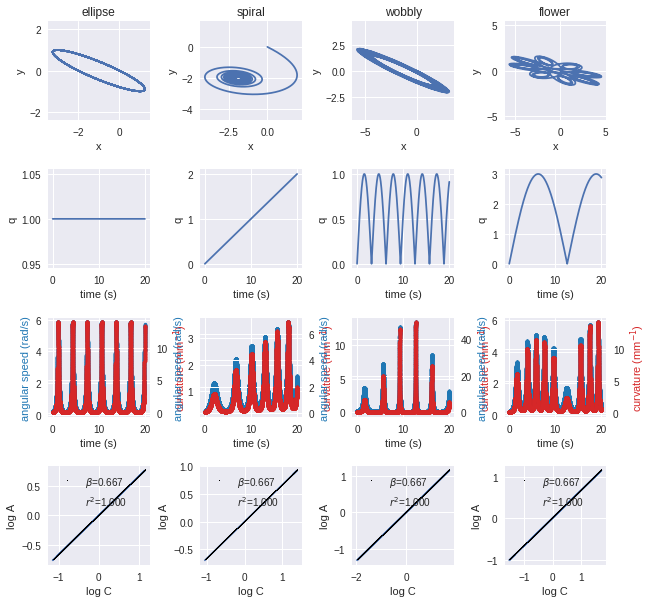

In [6]:
style.use("seaborn")
figure(figsize=[10, 10])
subplots_adjust(hspace=0.5, wspace=0.5)

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(4, 4, i+1)
  title(curve)
  plot(c.x, c.y)
  xlabel("x"); ylabel("y")
  axis("equal")
  
  subplot(4, 4, 4 + i+1)

  take = 20000
  
  plot(c.t[:take], c.q[:take])
  xlabel("time (s)")
  ylabel("q")
  
  c1 = "tab:blue"
  c2 = "tab:red"
  ax1 = subplot(4, 4, 8 + i + 1)
  ax1.set_xlabel("time (s)")
  ax1.set_ylabel("angular speed (rad/s)", color=c1)
  ax1.plot(c.t[:take], abs(c.A[:take]), ".", color=c1)
  ax2 = ax1.twinx()
  ax2.plot(c.t[:take], c.C[:take], ".", color= c2)
  ax2.set_ylabel(r"curvature (mm$^{-1}$)", color=c2)
  
  subplot(4, 4, 12 + i+1)
  plot(c.logC, c.logA)
  beta, offset, r, p_v, std_err = stats.linregress(c.logC, c.logA)
  r2 = r*r
  reg_line1 = [beta * i + offset for i in c.logC]
  plot(c.logC, reg_line1, ',', color="black", label=r"$\beta$={:.3f}".format(beta))
  plot([],[], color=(0,0,0,0), label="$r^2$={:.3f}".format(r2))
  legend(loc=2)
  xlabel("log C")
  ylabel("log A")
  
  
show()
  
  

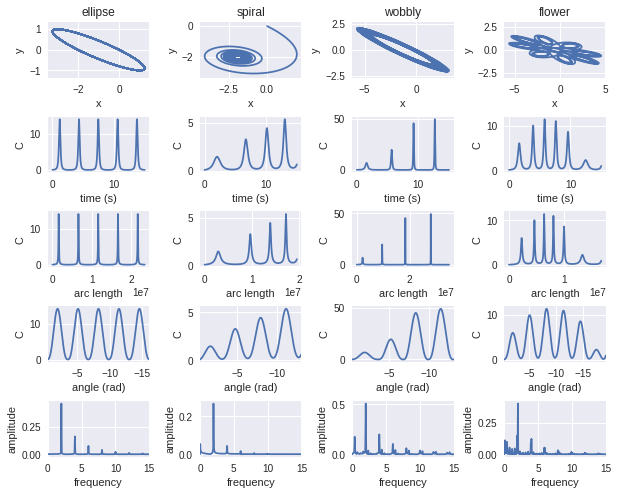

In [0]:
style.use("seaborn")
figure(figsize=[10, 8])
subplots_adjust(hspace=0.7, wspace=0.5)


for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(5, 4, i+1)
  title(curve)
  plot(c.x, c.y)
  xlabel("x"); ylabel("y")
  axis("equal")
  
  tk = 15000
  subplot(5, 4, 4 + i + 1)
  plot(c.t[:tk], c.C[:tk])
  ylabel("C")
  xlabel("time (s)")
  
  subplot(5, 4, 8 + i + 1)
  plot(c.s[:tk], c.C[:tk])
  ylabel("C")
  xlabel("arc length")
  
  subplot(5, 4, 12 + i + 1)
  plot(c.angle[:tk], c.C[:tk])
  xlim(c.angle[0], c.angle[tk])
  ylabel("C")
  xlabel("angle (rad)")
  
  subplot(5, 4, 16 + i + 1)
  plot(c.spectrum_F, c.spectrum_Y)
  xlim(0, 15)
  xlabel("frequency")
  ylabel("amplitude")
show()

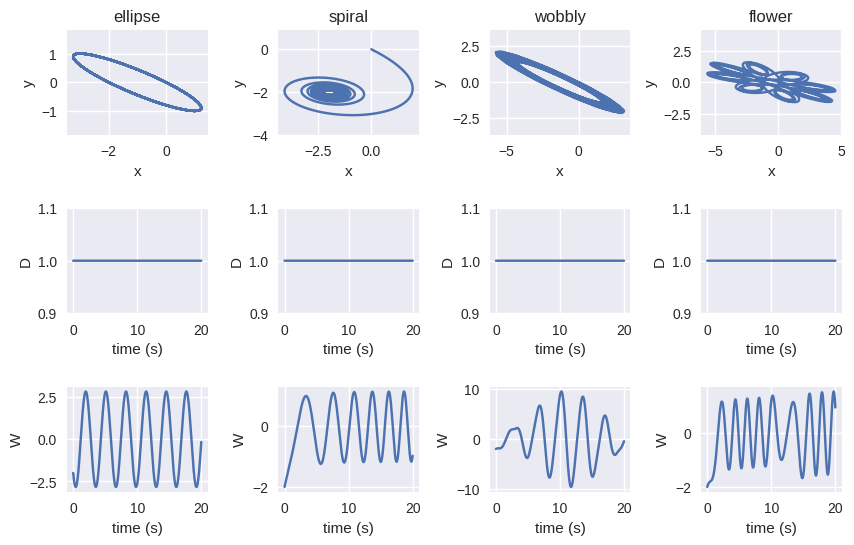

In [0]:
style.use("seaborn")
figure(figsize=[10, 6])
subplots_adjust(hspace=0.7, wspace=0.5)

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(3, 4, i+1)
  title(curve)
  plot(c.x, c.y)
  xlabel("x"); ylabel("y")
  axis("equal")
  
  take = arange(0, int(20 / dt))

  subplot(3, 4, 4 + i+1)
  plot(c.t[take], c.D[take])
  mD = mean(c.D)
  ylim(mD-0.1, mD+0.1)
  ylabel("D")
  xlabel("time (s)")
  
  subplot(3, 4, 8 + i+1)
  plot(c.t[take], c.W[take])
  ylabel("W")
  xlabel("time (s)")
show()

In [0]:
def test_betas(xs, ys, ds, C, target_time, target_betas):
  jerks = []
  Ds = []
  times = []
  Dsums = []
  for target_beta in target_betas:
    ts = get_times(ds, C, target_time, target_beta)
    r = analyze(xs, ys, ts)
    jerks.append(r.J)
    Ds.append(r.D)
    Dsum = sum(r.D)*dt
    Dsums.append(Dsum)
    times.append(r.t)
  min_j_index = argmin(jerks)
  min_j_beta = target_betas[min_j_index]
  return {"target_betas": target_betas, "jerks": jerks, "Ds": Ds, "Dsums": Dsums,
          "times" : times,"min_j_index" : min_j_index, "min_j_beta":min_j_beta}

take = arange(0, int(15 / dt))

for column in curves.columns:
  c = curves[column]
  target_betas = [1/3, 2/3, 1.0] # arange(0.1, 1.2, 0.033) 
  c.betas = test_betas(c.x[take], c.y[take], c.ds[take], c.C[take], 15, target_betas)

  target_betas = arange(0.1, 1, 0.01) 
  c.BETAS = test_betas(c.x[take], c.y[take], c.ds[take], c.C[take], 15, target_betas)
  

**Integral (D)**

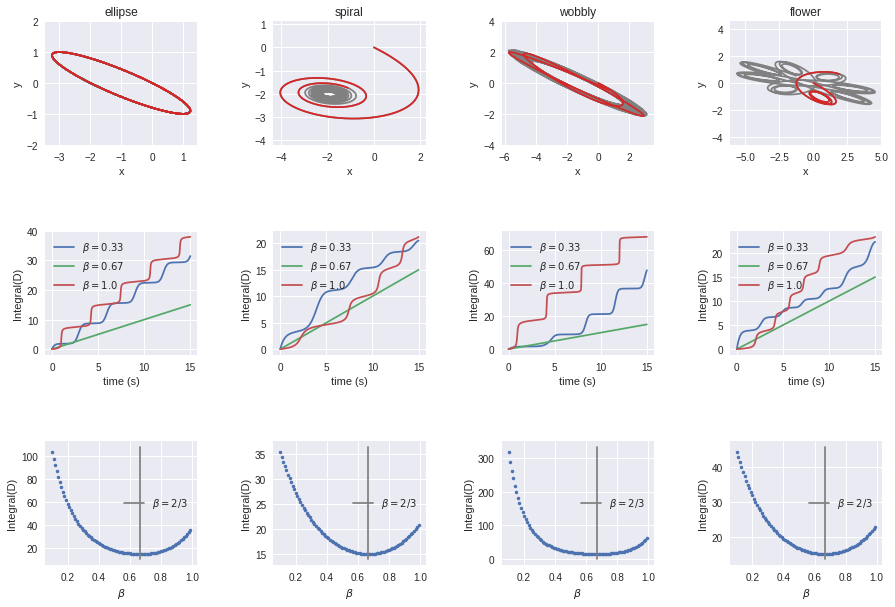

In [0]:
style.use("seaborn")
figure(figsize=(15, 10))
subplots_adjust(hspace=0.7, wspace=0.5)

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(3, 4, i+1)
  title(curve)
  plot(c.x, c.y, color="gray")
  plot(c.x[take], c.y[take], color="tab:red")
  xlabel("x"); ylabel("y")
  axis("equal")
  
  subplot(3, 4, 4 + i+1)
  for j, dd in enumerate(c.betas["Ds"]):
    I = cumsum(dd) * dt 
    b = c.betas["target_betas"][j]
    tt = c.betas["times"][j]
    plot(tt, I, label= r"$\beta={:.2}$".format(b))
  legend()
  ylabel("Integral(D)")
  xlabel("time (s)")

  subplot(3, 4, 8 + i+1 )
  
  plot(c.BETAS["target_betas"], c.BETAS["Dsums"], '.')
  plot([2/3, 2/3], gca().get_ylim(), "-",  color="gray", label=r"$\beta = 2/3$")
  
  xlabel(r"$\beta$")
  ylabel("Integral(D)")
  legend()
  
show()




# **Integral of D ^ (1/3)**

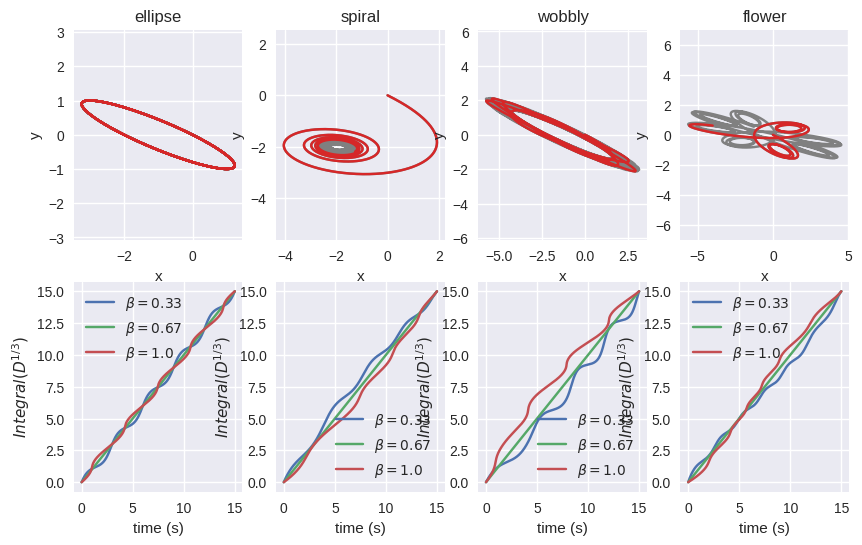

In [0]:
style.use("seaborn")
figure(figsize=[10, 6])

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(2, 4, i+1)
  title(curve)
  plot(c.x, c.y, color="gray")
  plot(c.x[take], c.y[take], color="tab:red")
  xlabel("x"); ylabel("y")
  axis("equal")
  
  subplot(2, 4, 4 + i+1)

  for i, dd in enumerate(c.betas["Ds"]):
    I = cumsum(asarray(dd)**(1/3)) * dt 
    b = c.betas["target_betas"][i]
    tt = c.betas["times"][i]
    plot(tt, I, label= r"$\beta={:.2}$".format(b))
    
  legend()
  ylabel(r"$Integral(D  ^ {1/3})$")
  xlabel("time (s)")
show()



0.6599999999999997
0.6399999999999997
0.6599999999999997
0.6499999999999997


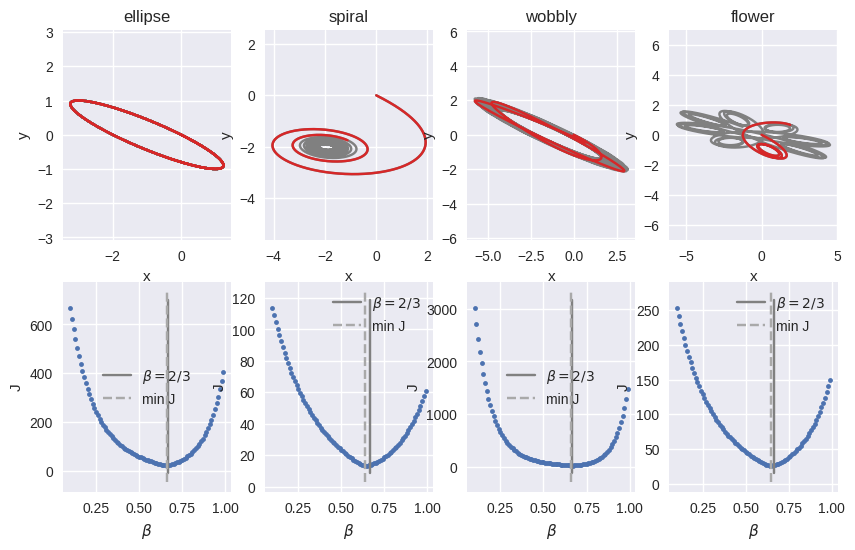

In [0]:
style.use("seaborn")
figure(figsize=[10, 6])
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  subplot(2, 4, i+1)
  title(curve)
  plot(c.x, c.y, color="gray")
  plot(c.x[take], c.y[take], color="tab:red")
  xlabel("x"); ylabel("y")
  axis("equal")
  
  subplot(2,4,4 + i+1 )
  plot(c.BETAS["target_betas"], c.BETAS["jerks"], '.')
  plot([2/3, 2/3], gca().get_ylim(), "-",  color="gray", label=r"$\beta = 2/3$")
  
  j = c.BETAS["min_j_index"]
  beta = c.BETAS["target_betas"][j]
  jerk = c.BETAS["jerks"][j]
  
  plot([beta, beta], gca().get_ylim(), "--",  color="darkgray", label=r"min J")
  xlabel(r"$\beta$")
  ylabel("J")
  legend()
  
  
  print(c.BETAS["min_j_beta"])
show()

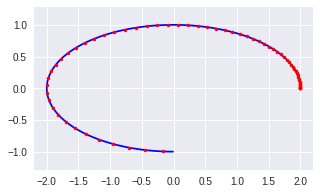

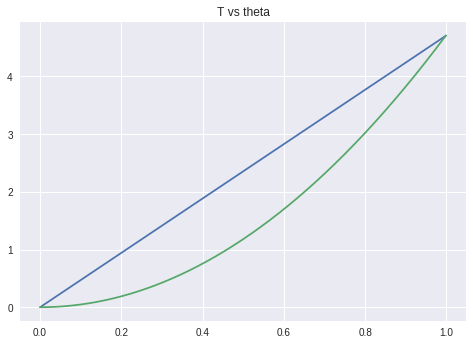

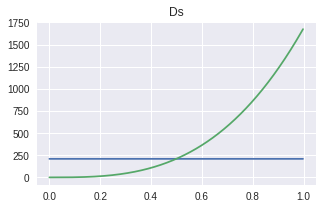

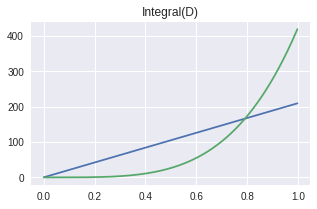

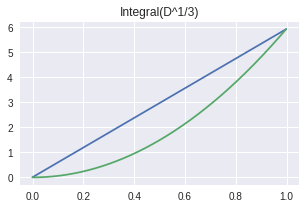

In [8]:

figure(figsize=(5, 3))

t = arange(0, 1, 0.001)
th = t * 1.5 * pi
x = 2 * cos(th)
y = 1 * sin(th)
plot(x, y,  c="blue")
axis("equal")


t2 = t**2
th2 = 1.5 * pi * t2 / t2[-1]  
x2 = 2 * cos(th2)
y2 = 1 * sin(th2)
plot(x2 [::15], y2[::15], ".", c="red")
show()

title("T vs theta")
plot(t, th, label="th=t")
plot(t, th2, label=r"$th=t^2$")
show()

r1 = analyze(x, y, t)
r2 = analyze(x2, y2, t)

figure(figsize=(5, 3))
plot(r1.t, r1.D)
plot(r2.t, r2.D)
title("Ds")
show()

figure(figsize=(5, 3))
title("Integral(D)")
plot(r1.t, cumsum(r1.D) * dt)
plot(r2.t, cumsum(r2.D) * dt)
show()

figure(figsize=(5, 3))
title("Integral(D^1/3)")
plot(r1.t, cumsum(r1.D**(1/3))*dt)
plot(r2.t, cumsum(r2.D**(1/3))*dt)
show()


0.0 10.0
0.0 10.0
0.0 10.0
0.0 10.0
0.0 10.0
0.0 10.0


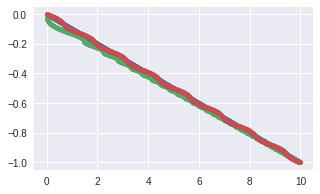

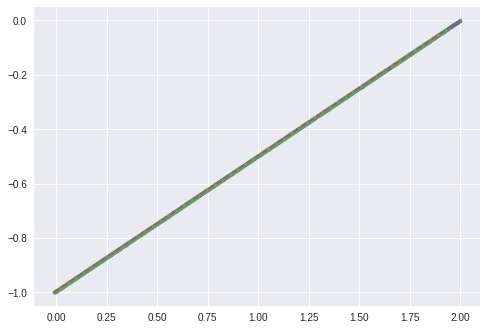

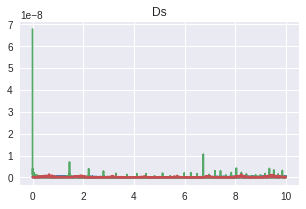

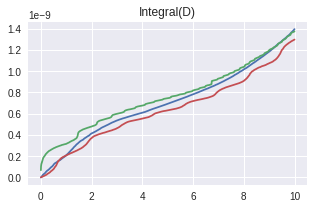

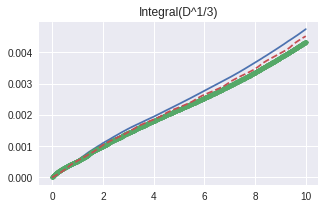

In [46]:

figure(figsize=(5, 3))

t = linspace(0, 10, 10000)
ta = linspace(0, 10, 10000)
tb = linspace(0, 10, 10000)

Ax, Ay = x[0], y[0]
Bx, By = x[-1], y[-1]

x0 = linspace(Ax, Bx, 10000)
y0 = linspace(Ay, By, 10000)

t10 = t
t20 = cumsum(abs(sin(t**2)))
t30 = cumsum(2 + cos(5*t))

t10 = t10 - t10[0] 
t20 = t20 - t20[0] 
t30 = t30 - t30[0] 
t1 = 10 * t10 / t10[-1] 
t2 = 10 * t20 / t20[-1] 
t3 = 10 * t30 / t30[-1] 

print(t1[0], t1[-1] )
print(t2[0], t2[-1] )
print(t3[0], t3[-1] )


x1 = interpolate.UnivariateSpline(t1, x0, k=3, s=0)(t)
y1 = interpolate.UnivariateSpline(t1, y0, k=3, s=0)(t)

x2 = interpolate.UnivariateSpline(t2, x0, k=3, s=0)(t)
y2 = interpolate.UnivariateSpline(t2, y0, k=3, s=0)(t)

x3 = interpolate.UnivariateSpline(t3, x0, k=3, s=0)(t)
y3 = interpolate.UnivariateSpline(t3, y0, k=3, s=0)(t)

print(t1[0], t1[-1] )
print(t2[0], t2[-1] )
print(t3[0], t3[-1] )
pass

plot(t, y1, '.')
plot(t, y2, '.')
plot(t, y3, '.')

show()

plot(x1[::10], y1[::10], '.')
plot(x2[::10], y2[::10], '.')
plot(x3[::10], y3[::10], '--')

show()


r1 = analyze(x1, y1, t)
r2 = analyze(x2, y2, t)
r3 = analyze(x3, y3, t)


figure(figsize=(5, 3))
plot(r1.t, r1.D)
plot(r2.t, r2.D)
plot(r3.t, r3.D)


title("Ds")
show()

figure(figsize=(5, 3))
title("Integral(D)")
plot(r1.t, cumsum(r1.D) * dt)
plot(r2.t, cumsum(r2.D) * dt)
plot(r3.t, cumsum(r3.D) * dt)

show()

figure(figsize=(5, 3))
title("Integral(D^1/3)")
plot(r1.t, cumsum(r1.D**(1/3)) * dt)
plot(r2.t, cumsum(r2.D**(1/3)) * dt, '.')
plot(r3.t, cumsum(r3.D**(1/3)) * dt, '--')

show()

9.999 9.999
3.382163121481596e-16 5.8800505071243074e-15 3.6866801511635205e-16


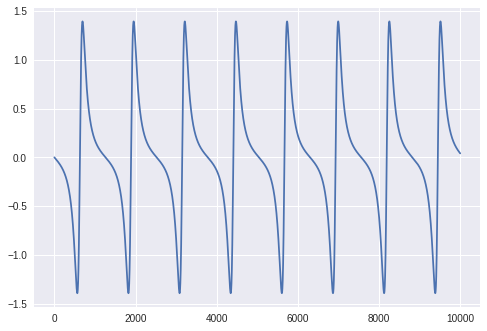

In [47]:
print(r1.t[-1], r2.t[-1])
plot(r3.xacc)
print(sum(r1.D**(1^3)), sum(r2.D**(1^3)),sum(r3.D**(1^3)) )


In [0]:
def get_polar_rose(k, A, theta):
  xs = A * np.cos(k * theta) * np.cos(theta) 
  ys = A * np.cos(k * theta) * np.sin(theta)
  return xs, ys

33.69
0.6666663488035435 0.9999999999999964


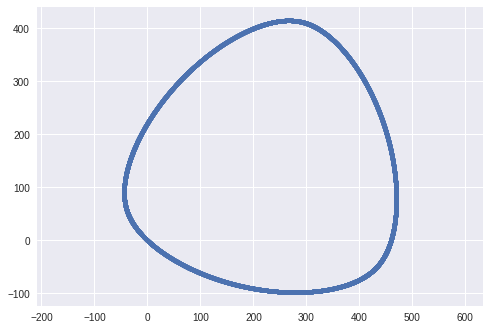

0.7799999999999997 0.2200000000000003


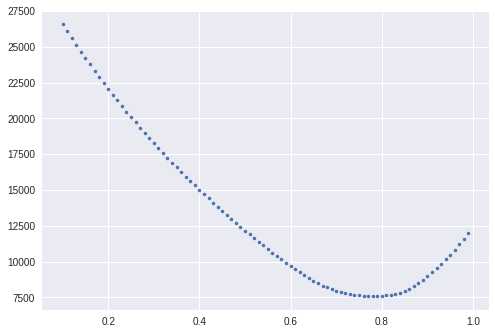

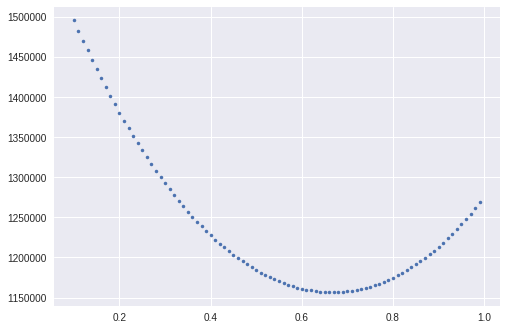

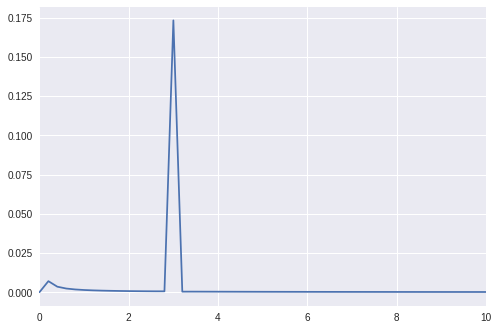

In [0]:
def get_trajectory_times(xs, ys, target_time, target_beta):
  ts = np.zeros(len(xs))
  for i in range(1, len(xs) - 1):
    a = distance(xs[i-1], ys[i-1], xs[i], ys[i])
    b = distance(xs[i+1], ys[i+1], xs[i], ys[i])
    c = distance(xs[i+1], ys[i+1], xs[i-1], ys[i-1])
    C = (4 * triangle_area(a, b, c)) / (a * b * c)
    dt = a / (C**(target_beta - 1))
    ts[i] = ts[i-1] + dt
  ts = ts * (target_time / ts[-2])
  return ts
  

def test_betas1(xs, ys, ds, C, target_time, target_betas):
  jerks = []
  Ds = []
  times = []
  Dsums = []
  for target_beta in target_betas:
    ts = get_times(ds, C, target_time, target_beta)
    r = analyze(xs[:-1], ys[:-1], ts[:-1])
    #plot(r.xjerk)
    #show()
    J = sum(sqrt(r.xjerk**2 + r.yjerk**2)) * dt
    D = r.D
    jerks.append(J)
    Ds.append(D)
    Dsum = sum(D)*dt
    Dsums.append(Dsum)
    times.append(r.t)
  min_j_index = argmin(jerks)
  min_j_beta = target_betas[min_j_index]
  return {"target_betas": target_betas, "jerks": jerks, "Ds": Ds, "Dsums": Dsums,
          "times" : times,"min_j_index" : min_j_index, "min_j_beta":min_j_beta}


def test_betas2(xs, ys, ds, C, target_time, target_betas):
  jerks = []
  Ds = []
  times = []
  Dsums = []
  for target_beta in target_betas:
    ts = get_trajectory_times(ds, C, target_time, target_beta)
    r = analyze(xs[:-2], ys[:-2], ts[:-2])
    J = sum(sqrt(r.xjerk**2 + r.yjerk**2)) * dt
    D = r.D
    jerks.append(J)
    Ds.append(D)
    Dsum = sum(D)*dt
    Dsums.append(Dsum)
    times.append(r.t)
  min_j_index = argmin(jerks)
  min_j_beta = target_betas[min_j_index]
  return {"target_betas": target_betas, "jerks": jerks, "Ds": Ds, "Dsums": Dsums,
          "times" : times,"min_j_index" : min_j_index, "min_j_beta":min_j_beta}

#def test_betas(xs, ys, ds, C, target_time, target_betas):

hx, hy, ht = get_pure_trajectory(eps = 0.8, v = 3, N=10, k=1, th0=-0.75)
print(ht[-1])
#plot(hx, hy)
r = analyze(hx, hy, ht, dt=0.001)
print(r.beta, r.r2)

dt =0.001
ds = r.V * dt
ss = test_betas(r.x, r.y, ds, r.C, target_time = 40, target_betas = arange(0.1, 1, 0.01))
plot(r.x, r.y, '.'); 
axis("equal")
show()
print(ss["min_j_beta"], 1- ss["min_j_beta"])

plot(ss["target_betas"], ss["jerks"], '.'); show()
plot(ss["target_betas"], ss["Dsums"], '.'); show()

#plot(log10(r.R), log10(r.V))
#lr = log10(r.R)
#lv = log10(r.V)
#print(stats.linregress(lr, lv))

f, y = pow_spec(hx, hy, ht)
xlim(0, 10)
plot(f, y)

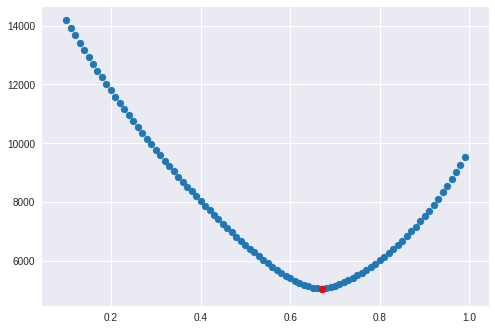

0.6699999999999997 0.3300000000000003


In [0]:
minJ = Infinity
minJB = Infinity
for tb in arange(0.1, 1, 0.01):
  hx, hy, ht = get_pure_trajectory(eps = 0.8, v = 2, N=10, k=1, th0=-0.75, beta=tb)
  ht2 = get_trajectory_times(hx, hy, 40, tb)
  r = analyze(hx[:-1], hy[:-1], ht2[:-1])
  J = sum(sqrt(r.xjerk **2 + r.yjerk**2))*dt
  scatter(r.beta, J, color="tab:blue")
  if J < minJ:
    minJ = J
    minJB = tb
    
scatter(minJB, minJ, color="red")
show()
print(minJB, 1-minJB)  

In [0]:

a1 = 1
a2 = 1
b1 = 0
b2 = 3
w = -0.0001
x = a1 * exp(w * t) + a2 * exp(-w * t)
y = b1 * exp(w * t) + b2 * exp(-w * t)
plot(x, y)

r = get_beta(x,y,t)

In [0]:
r["beta"]; r["r2"]; plot(r["t"])

In [0]:
from matplotlib import animation, rc
from matplotlib.patches import Polygon, Arrow, FancyArrowPatch as fap
#matplotlib.rcParams["animation.embed_limit"] = 100

style.use("seaborn")

rc('animation', html='jshtml')

c = curves.ellipse
#c = curves.wobbly
#c = curves.ellipse

fig, ax = subplots(figsize=(10, 6))
tk = arange(0, 6300, 100) 

r = analyze(c.x, c.y, c.t)

x = r.x[tk]
y = r.y[tk]
dx = r.xvel[tk]
dy = r.yvel[tk]
ddx = r.xacc[tk]
ddy = r.yacc[tk]
xj = r.xjerk[tk]
yj = r.yjerk[tk]
Wc = abs(ddx*dx + ddy*dy)

m = ax.scatter(x=x , y=y, c=Wc, cmap="seismic")#, vmin=0, vmax=+2)
CB = fig.colorbar(m, orientation='vertical', shrink = 0.8)
CB.ax.set_ylabel("W")

vk = 1

def update(i):
  pxs = [x[i], x[i] + vk* dx[i], x[i] + vk * dx[i] + vk * ddx[i], x[i] + vk* ddx[i]]
  pys = [y[i], y[i] + vk* dy[i], y[i] + vk * dy[i] + vk * ddy[i], y[i] + vk* ddy[i]] 
  D_area = Polygon(xy = asarray(list(zip(pxs, pys))), color="black", closed=True, fill=False, hatch="///", label="D")
  p1 = fap((x[i], y[i]), (x[i] + vk * dx[i],  y[i] + vk * dy[i]),  color="red", mutation_scale=20, label=r"$\vec v$")
  p2 = fap((x[i], y[i]), (x[i] + vk * ddx[i], y[i] + vk * ddy[i]),  color="blue", mutation_scale=20, label=r"$\vec a$")
  p3 = fap((x[i], y[i]), (x[i] + vk * xj[i], y[i] + vk * yj[i]),  color="darkgreen", mutation_scale=20, label=r"$\vec j$")
  return [D_area, p1, p2, p3]

for p in update(0): ax.add_patch(p)
xlabel("x")
ylabel("y")
legend()
#show()
ax.axis("equal")
#ax.axis([-3.5, 2, -1.5, 1.5])
close()

def animate(i, ax):
  ax.axis("equal")
  ax.patches = []
  patches = update(i) 
  for p in patches: ax.add_patch(p)
  return [0,0]

animation.FuncAnimation(fig, animate, arange(len(tk)), interval = 150, fargs=[ax])

#show()

In [0]:
show()

# Power spectra

KinematicCognition-Analysis/data-new/February1986MasDer tracing flower3 10.4.2019. 16.07.49 .txt
KinematicCognition-Analysis/data-new/February1986MasDer tracing flower4 10.4.2019. 16.08.27 .txt


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


KinematicCognition-Analysis/data-new/February1986MasDer scribble 10.4.2019. 15.23.12.txt
KinematicCognition-Analysis/data-new/user February1986MasDer tracking hyper 10.4.2019. 16.10.19 .txt


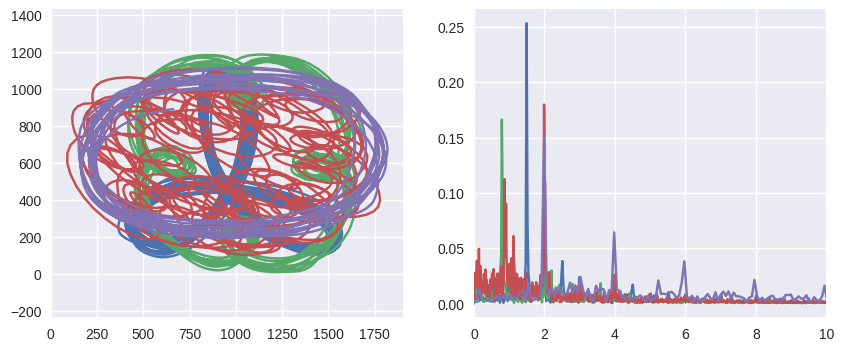

In [0]:
#import pandas as pd
#from matplotlib.pyplot import *
#!git clone https://github.com/adam-matic/KinematicCognition-Analysis
fs = glob.glob("KinematicCognition-Analysis/data-new/*.txt")
ffs = [fs[9], fs[0], fs[3], fs[4]]

figure(figsize=(10, 4))

for f in ffs:
  print(f)
  d = pd.read_csv(f, sep = " ", names = ["t", "x", "y"])
  d.t /= 1000
  subplot(1,2,1)
  plot(d.x, d.y)
  axis("equal")

  subplot(1,2,2)
  f, y = pow_spec(d.x, d.y, d.t, cutoff=10)
  xlim(0, 10)
  plot(f, y)
show()


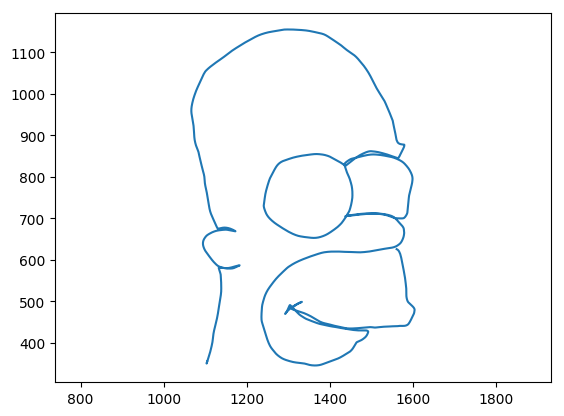

0.7043574333101974 0.8612403696246514
0.7037213950679437 0.9980270384811378


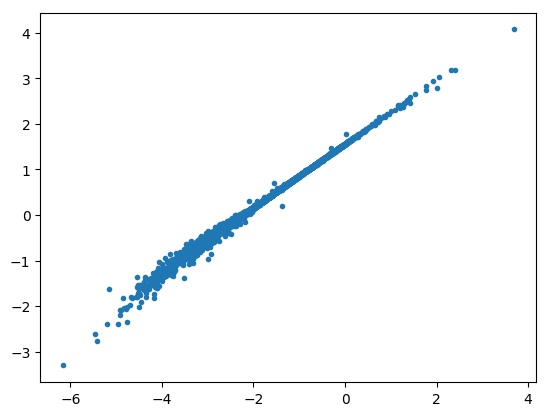

In [0]:
import glob
style.use("default")
#!git clone https://github.com/adam-matic/tracing_images
fs = glob.glob("tracing_images/*.txt")

f =  fs[0]
tr, xr, yr = loadtxt(f, skiprows=200, unpack=True)
dt=0.001
x, y, t = sm(xr, yr, tr, dt, cutoff = 8)
take = arange(0, len(t) - int(1.8/dt))

plot(x[take], y[take])
axis("equal")
show()
r = analyze(x[take], y[take], t[take], dt)
print(r.beta, r.r2)

h066 = retrack(x[take], y[take], t[take], target_time = None, target_beta =0.7)

plot(h066.logC, h066.logA, '.')



print(h066.beta, h066.r2)

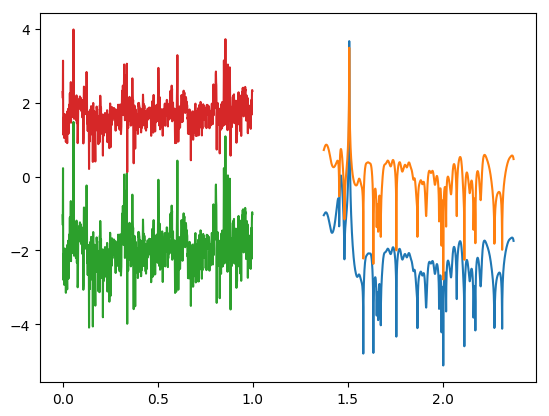

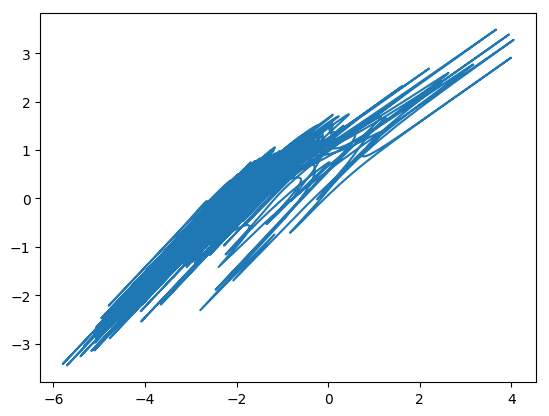

In [0]:
tk = arange(0, int(1/dt))
plot(r.t[tk], r.logC[tk])
plot(r.t[tk], r.logA[tk])

plot(h066.t[tk], h066.logC[tk])
plot(h066.t[tk], h066.logA[tk])

#plot(r.x[tk])
show()
plot(r.logC, r.logA)

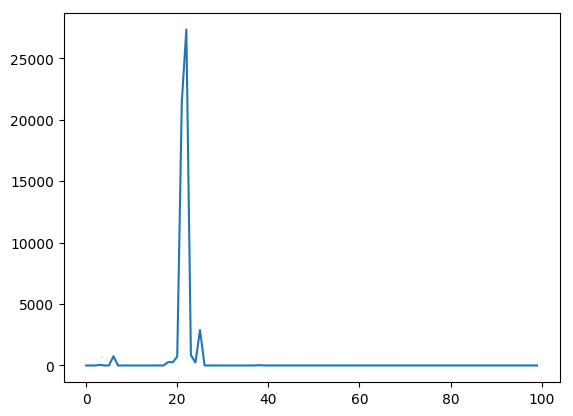